In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Synthetic Dataset

In [2]:
results = {
    "0": {
        "model_name": "MLP",
        "test_metrics":{
            "accuracy": 0.9990,
            "precision": 0.9443,
            "recall": 0.9888,
            "f1_score": 0.9661,
            "f2_score": 0.9808,
            "auc_roc": 0.9983,
            "pr_auc": 0.9929
        },
        "green_metrics":{
            "latency_ms": 0.1302,
            "flops_gflops": 0.0000,
            "size_model_mb": 0.0015,
            "energy_consumed_kwh": 0.0052,
            "emissions_kg_co2e": 0.0015,
            "carbon_intensity_kg_co2e_per_kwh": 0.2908
        }
    },
    "1": {
        "model_name": "XGBOOST_CNN_BILSTM",
        "test_metrics":{
            "accuracy": 0.9986,
            "precision": 0.9247,
            "recall": 0.9808,
            "f1_score": 0.9519,
            "f2_score": 0.9691,
            "auc_roc": 0.9988,
            "pr_auc": 0.9863
        },
        "green_metrics":{
            "latency_ms": 3.4214,
            "flops_gflops": 0.0016,
            "size_model_mb": 0.6514,
            "energy_consumed_kwh": 1.8501,
            "emissions_kg_co2e": 0.5380,
            "carbon_intensity_kg_co2e_per_kwh": 0.2908
        }
    },
    "2": {
        "model_name": "GREEN_MODEL",
        "test_metrics":{
            "accuracy": 0.9989,
            "precision": 0.9519,
            "recall": 0.9718,
            "f1_score": 0.9618,
            "f2_score": 0.9678,
            "auc_roc": 0.9998,
            "pr_auc": 0.9845
        },
        "green_metrics":{
            "latency_ms": 1.5926,
            "flops_gflops": 0.0005,
            "size_model_mb": 0.0179,
            "energy_consumed_kwh": 0.0155,
            "emissions_kg_co2e": 0.0045,
            "carbon_intensity_kg_co2e_per_kwh": 0.2908
        }
    },
    "3": {
        "model_name": "GREEN_MODEL + PRUNING",
        "test_metrics":{
            "accuracy": 0.9996,
            "precision": 0.8725,
            "recall": 0.9976,
            "f1_score": 0.9849,
            "f2_score": 0.9925,
            "auc_roc": 0.9999,
            "pr_auc": 0.9930
        },
        "green_metrics":{
            "latency_ms": 4.2799,
            "flops_gflops": 0.0005,
            "size_model_mb": 0.0179,
            "energy_consumed_kwh": 0.0137,
            "emissions_kg_co2e": 0.0040,
            "carbon_intensity_kg_co2e_per_kwh": 0.2909
        }
    }
}


-> DatAFrames

In [3]:
records = []
green_records = []

for k, v in results.items():
    model_name = v.get("model_name") or v.get("model")
    test = v.get("test_metrics", {})
    green = v.get("green_metrics") or v.get("green_evaluation", {})

    records.append({
        "model": model_name,
        "accuracy": test.get("accuracy"),
        "precision": test.get("precision"),
        "recall": test.get("recall"),
        "f1_score": test.get("f1_score"),
        "auc_roc": test.get("auc_roc"),
        "pr_auc": test.get("pr_auc")
    })

    green_records.append({
        "model": model_name,
        "latency_ms": green.get("latency_ms"),
        "flops_gflops": green.get("flops_gflops"),
        "size_model_mb": green.get("size_model_mb"),
        "emissions_kg_co2e": green.get("emissions_kg_co2e")
    })

df_perf = pd.DataFrame(records)
df_green = pd.DataFrame(green_records)

sns.set(style="whitegrid", font_scale=1.1)


Composite green score

In [4]:
def compute_green_score(df):
    temp = df.copy()
    for col in ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]:
        temp[col] = (temp[col] - temp[col].min()) / (temp[col].max() - temp[col].min())
    # invert (lower = better)
    temp["green_score"] = 1 - temp[["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]].mean(axis=1)
    return temp

df_green_score = compute_green_score(df_green)
df_summary = df_perf.merge(df_green_score[["model", "green_score"]], on="model")

## Performance metrics

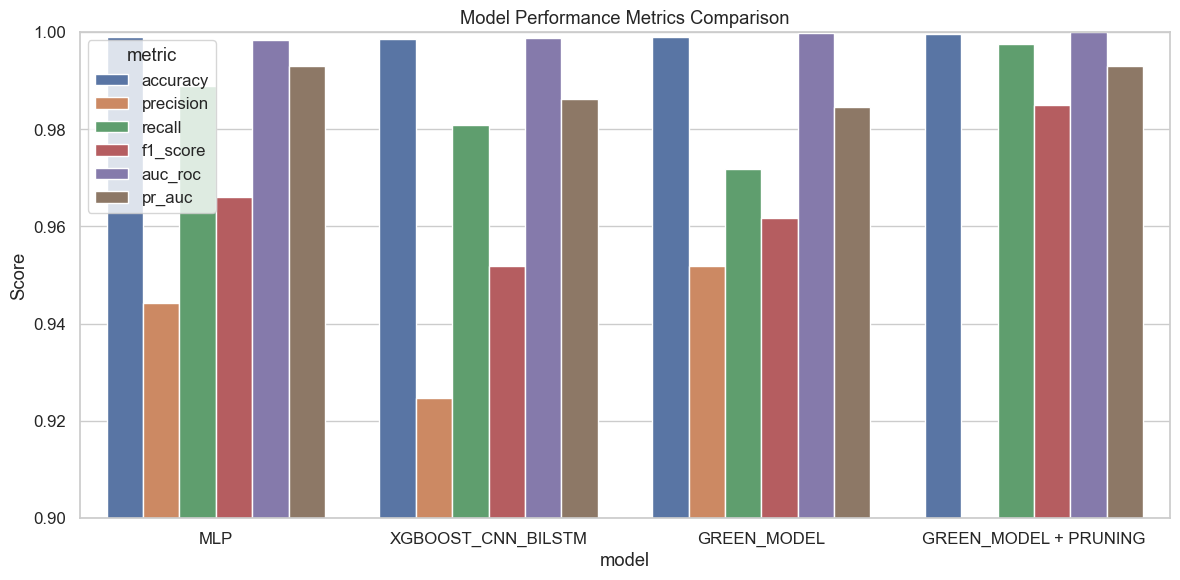

In [5]:
melted_perf = df_perf.melt(id_vars="model", var_name="metric", value_name="score")
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_perf, x="model", y="score", hue="metric", errorbar=None)
plt.title("Model Performance Metrics Comparison")
plt.ylim(0.9, 1.0)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

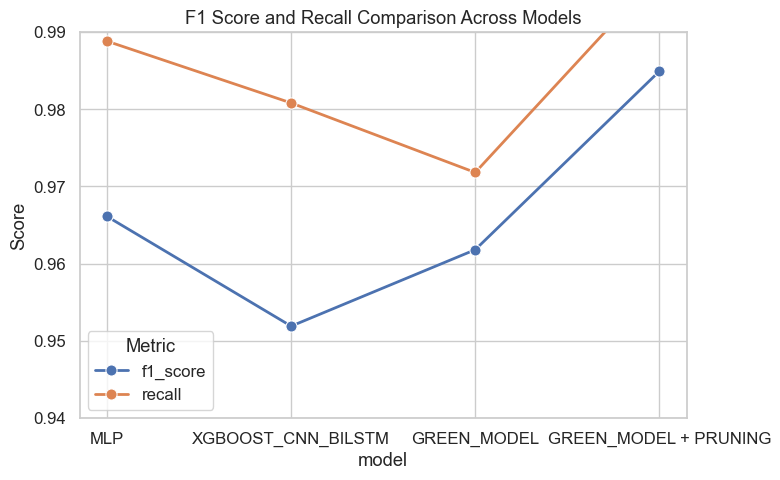

In [6]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_perf.melt(id_vars="model", value_vars=["f1_score", "recall"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="o", linewidth=2, markersize=8)
plt.title("F1 Score and Recall Comparison Across Models")
plt.ylabel("Score")
plt.ylim(0.94, 0.99)
plt.tight_layout()
plt.show()

## Green AI metrics

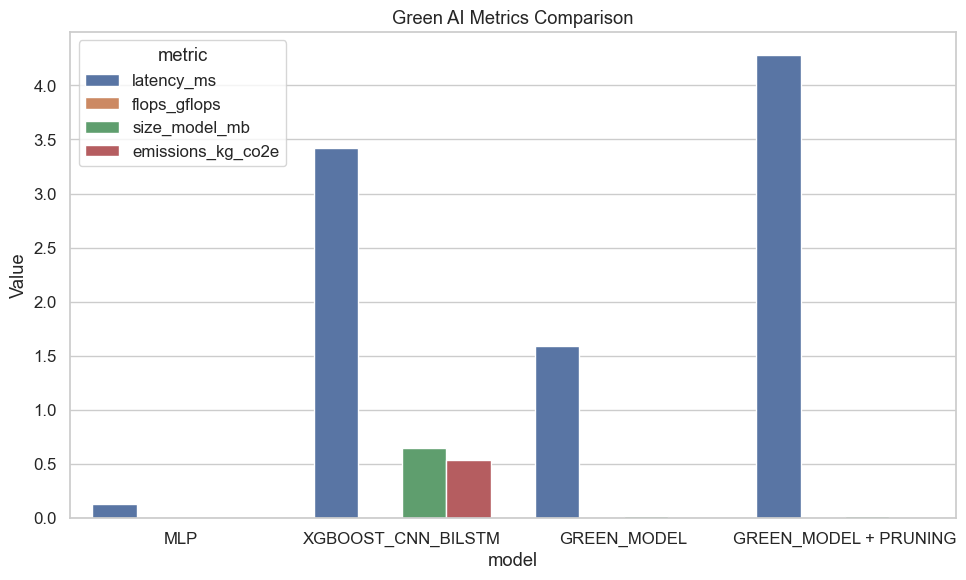

In [7]:
melted_green = df_green.melt(id_vars="model", var_name="metric", value_name="value")
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_green, x="model", y="value", hue="metric", errorbar=None)
plt.title("Green AI Metrics Comparison")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

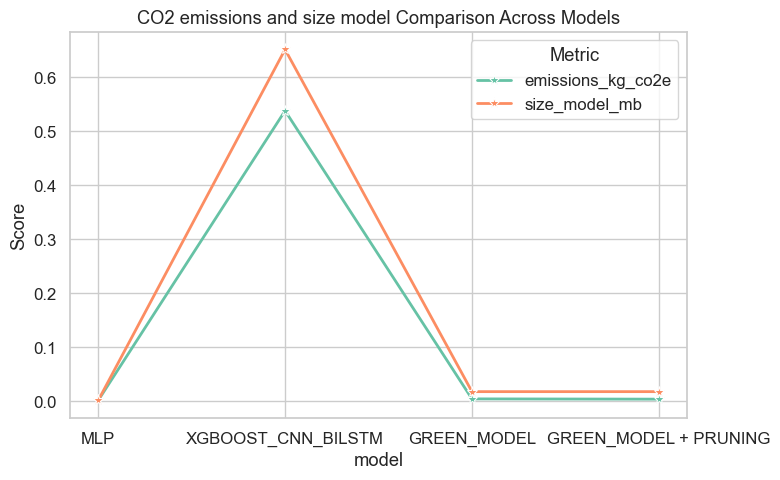

In [8]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_green.melt(id_vars="model", value_vars=["emissions_kg_co2e", "size_model_mb"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="*", linewidth=2, markersize=8, palette="Set2")
plt.title("CO2 emissions and size model Comparison Across Models")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

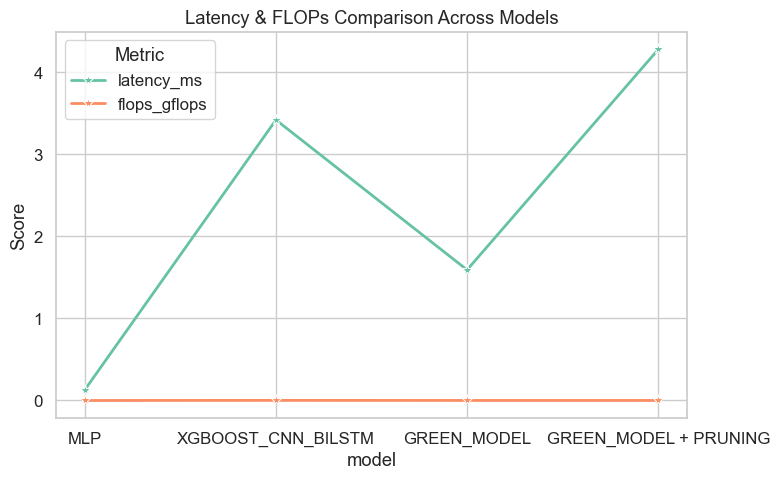

In [9]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_green.melt(id_vars="model", value_vars=["latency_ms", "flops_gflops"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="*", linewidth=2, markersize=8, palette="Set2")
plt.title("Latency & FLOPs Comparison Across Models")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

## Green score 

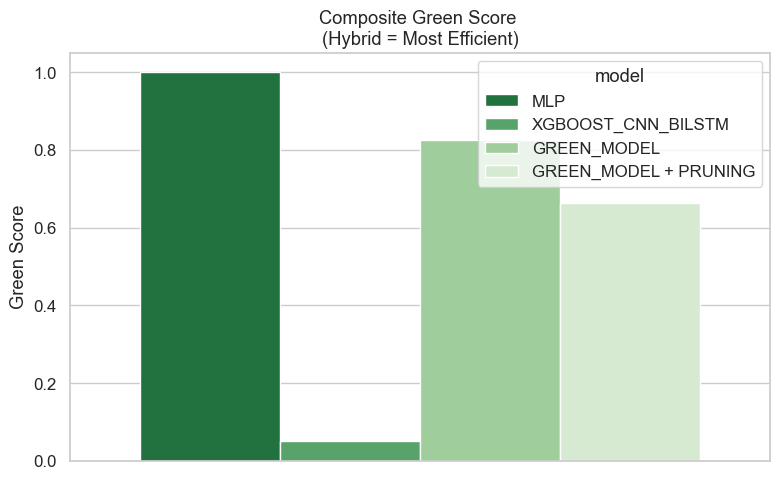

In [10]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_green_score, hue="model", y="green_score", palette="Greens_r")
plt.title("Composite Green Score \n(Hybrid = Most Efficient)")
plt.ylabel("Green Score")
plt.tight_layout()
plt.show()

## Trade off: F1 vs Emissions

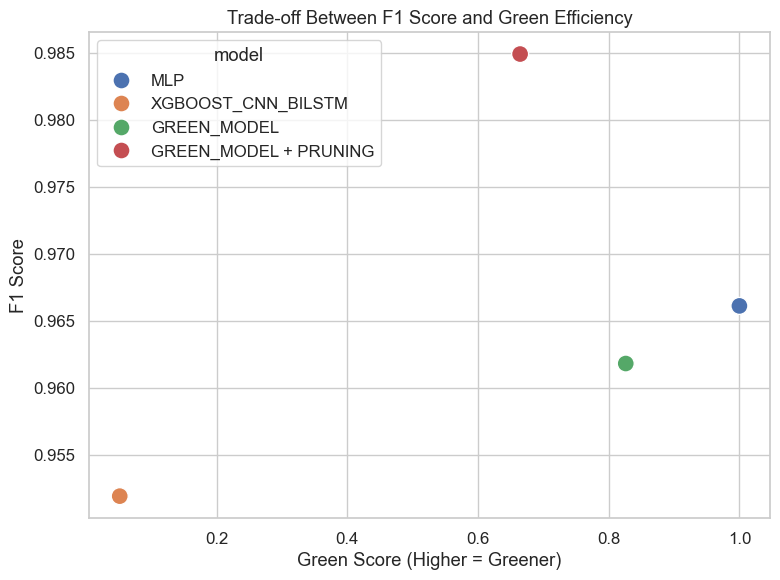

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_summary, x="green_score", y="f1_score", hue="model", s=150)
plt.title("Trade-off Between F1 Score and Green Efficiency")
plt.xlabel("Green Score (Higher = Greener)")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

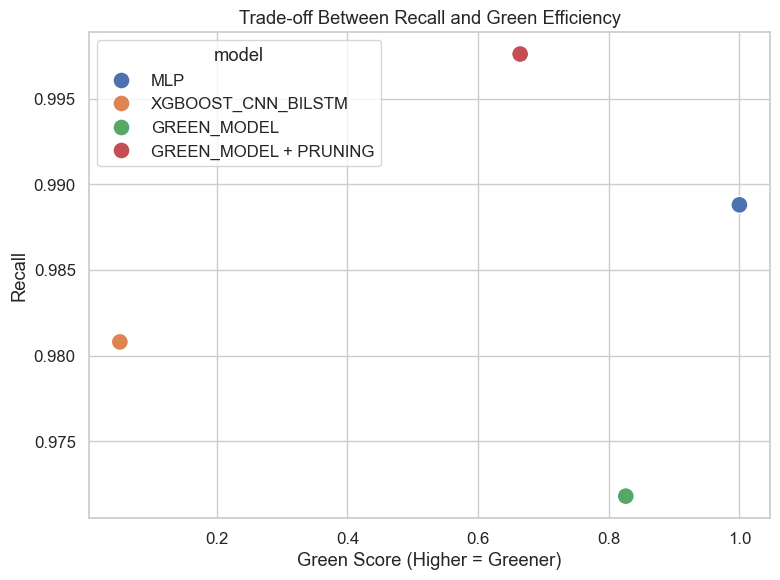

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_summary, x="green_score", y="recall", hue="model", s=150)
plt.title("Trade-off Between Recall and Green Efficiency")
plt.xlabel("Green Score (Higher = Greener)")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()

## Radar Chart -> Performance & Green tradeoff

In [13]:
def radar_chart(df, title, metrics):
    labels = metrics
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, row in df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, label=row["model"])
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    plt.title(title, size=14)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Normalize for better visualization
df_green_norm = df_green.copy()
for col in df_green_norm.columns[1:]:
    df_green_norm[col] = (df_green_norm[col] - df_green_norm[col].min()) / (df_green_norm[col].max() - df_green_norm[col].min())

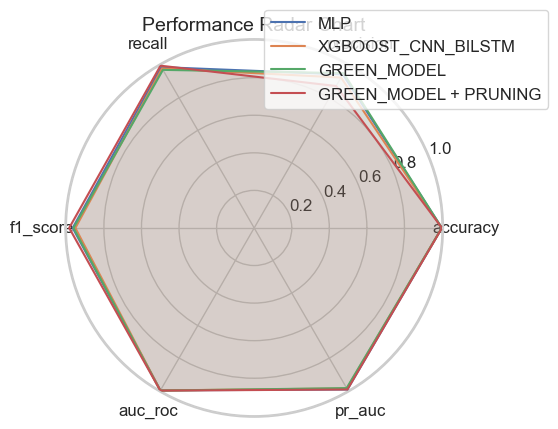

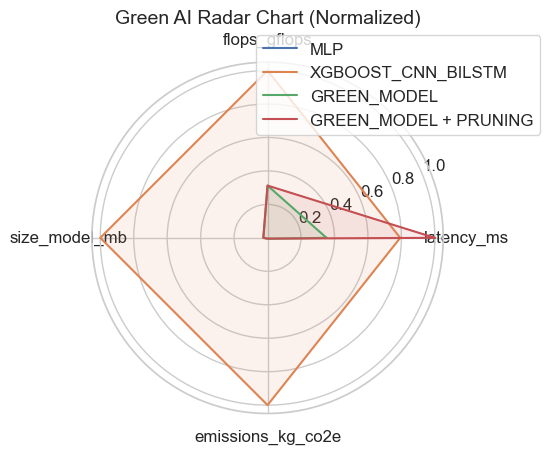

In [14]:
radar_chart(df_perf, "Performance Radar Chart", ["accuracy", "precision", "recall", "f1_score", "auc_roc", "pr_auc"])
radar_chart(df_green_norm, "Green AI Radar Chart (Normalized)", ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"])

# Creditcard Dataset    

In [15]:
results = {
    "0": {
        "model_name": "MLP 1",
        "test_metrics":{
            "accuracy": 0.9989,
            "precision": 0.6392,
            "recall": 0.8378,
            "f1_score": 0.7251,
            "f2_score": 0.7888,
            "auc_roc": 0.9580,
            "pr_auc": 0.8153
        },
        "green_metrics":{
            "latency_ms": 0.1526,
            "flops_gflops": 0.0000,
            "size_model_mb": 0.1669,
            "emissions_kg_co2e": 0.0001
        }
    },
    "1": {
        "model_name": "MLP 2",
        "test_metrics":{
            "accuracy": 0.9990,
            "precision": 0.6667,
            "recall": 0.8108,
            "f1_score": 0.7317,
            "f2_score": 0.7772,
            "auc_roc": 0.9543,
            "pr_auc": 0.8242
        },
        "green_metrics":{
            "latency_ms": 0.1847,
            "flops_gflops": 0.0000,
            "size_model_mb": 0.1846,
            "emissions_kg_co2e": 0.0003
        }
    },
    "2": {
        "model_name": "XGBOOST_CNN_BILSTM",
        "test_metrics":{
            "accuracy": 0.9993,
            "precision": 0.8194,
            "recall": 0.8082,
            "f1_score": 0.8082,
            "f2_score": 0.8016,
            "auc_roc": 0.9495,
            "pr_auc": 0.7819
        },
        "green_metrics":{
            "latency_ms": 0.9993,
            "flops_gflops": 0.8194,
            "size_model_mb": 0.8082,
            "emissions_kg_co2e": 0.0007
        }
    },
    "3": {
        "model_name": "GREEN_MODEL",
        "test_metrics":{
            "accuracy": 0.9996,
            "precision": 0.9231,
            "recall": 0.8108,
            "f1_score": 0.8633,
            "f2_score": 0.8310,
            "auc_roc": 0.9409,
            "pr_auc": 0.8482
        },
        "green_metrics":{
            "latency_ms": 0.9996,
            "flops_gflops": 0.9231,
            "size_model_mb": 0.8108,
            "emissions_kg_co2e": 0.0005
        }
    },
    "4": {
        "model_name": "GREEN_MODEL + PRUNING",
        "test_metrics":{
            "accuracy": 0.9994,
            "precision": 0.8472,
            "recall": 0.8243,
            "f1_score": 0.8356,
            "f2_score": 0.8288,
            "auc_roc": 0.9692,
            "pr_auc": 0.8339
        },
        "green_metrics":{
            "latency_ms": 0.9994,
            "flops_gflops": 0.8472,
            "size_model_mb": 0.8243,
            "emissions_kg_co2e": 0.0005
        }
    }
}


In [16]:
def compute_green_score(df, eps=1e-9, weights=None):
    temp = df.copy()
    cols = ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]
    if weights is None:
        weights = {c: 1.0 for c in cols}
    total_w = sum(weights.values())

    for col in cols:
        col_min = temp[col].min()
        col_max = temp[col].max()
        denom = max(col_max - col_min, eps)
        temp[col] = (temp[col] - col_min) / denom

    # weighted mean then invert
    vals = temp[cols].fillna(temp[cols].mean())  # simple NaN handling
    weighted_mean = sum(vals[c] * weights[c] for c in cols) / total_w
    temp["green_score"] = 1 - weighted_mean
    return temp

In [17]:
records = []
green_records = []

for k, v in results.items():
    model_name = v.get("model_name") or v.get("model")
    test = v.get("test_metrics", {})
    green = v.get("green_metrics") or v.get("green_evaluation", {})

    records.append({
        "model": model_name,
        "accuracy": test.get("accuracy"),
        "precision": test.get("precision"),
        "recall": test.get("recall"),
        "f1_score": test.get("f1_score"),
        "auc_roc": test.get("auc_roc"),
        "pr_auc": test.get("pr_auc")
    })

    green_records.append({
        "model": model_name,
        "latency_ms": green.get("latency_ms"),
        "flops_gflops": green.get("flops_gflops"),
        "size_model_mb": green.get("size_model_mb"),
        "emissions_kg_co2e": green.get("emissions_kg_co2e")
    })

df_perf = pd.DataFrame(records)
df_green = pd.DataFrame(green_records)

sns.set(style="whitegrid", font_scale=1.1)


In [18]:
def compute_green_score(df):
    temp = df.copy()
    for col in ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]:
        temp[col] = (temp[col] - temp[col].min()) / (temp[col].max() - temp[col].min())
    # invert (lower = better)
    temp["green_score"] = 1 - temp[["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]].mean(axis=1)
    return temp

df_green_score = compute_green_score(df_green)
df_summary = df_perf.merge(df_green_score[["model", "green_score"]], on="model")

In [19]:
def compute_green_score(df, eps=1e-9, weights=None):
    temp = df.copy()
    cols = ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"]
    if weights is None:
        weights = {c: 1.0 for c in cols}
    total_w = sum(weights.values())

    for col in cols:
        col_min = temp[col].min()
        col_max = temp[col].max()
        denom = max(col_max - col_min, eps)
        temp[col] = (temp[col] - col_min) / denom

    # weighted mean then invert
    vals = temp[cols].fillna(temp[cols].mean())  # simple NaN handling
    weighted_mean = sum(vals[c] * weights[c] for c in cols) / total_w
    temp["green_score"] = 1 - weighted_mean
    return temp

## Performance metrics

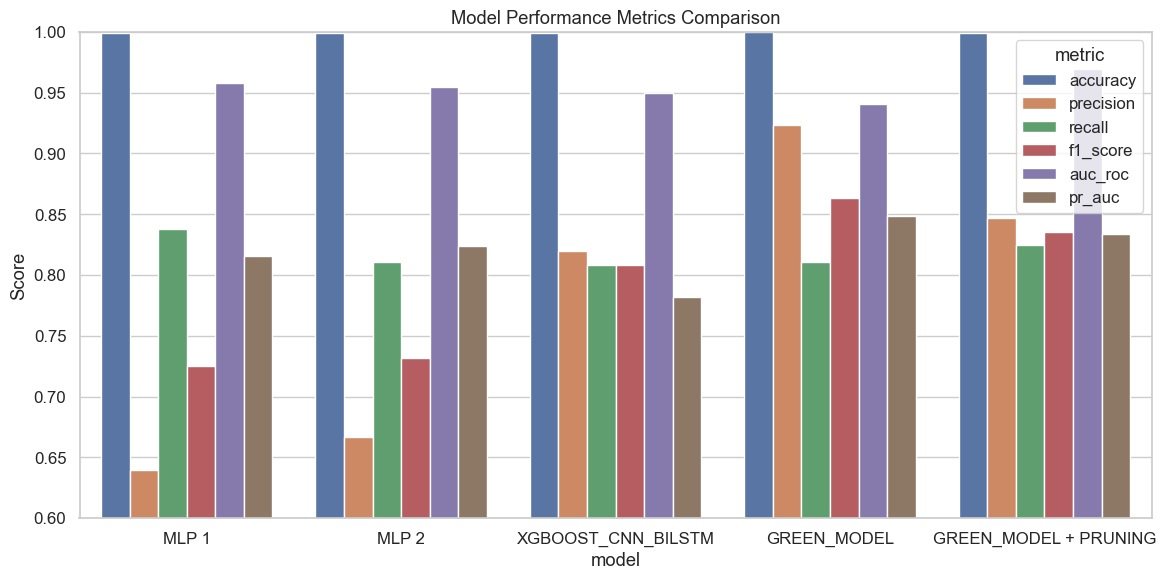

In [20]:
melted_perf = df_perf.melt(id_vars="model", var_name="metric", value_name="score")
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_perf, x="model", y="score", hue="metric", errorbar=None)
plt.title("Model Performance Metrics Comparison")
plt.ylim(0.6, 1.0)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

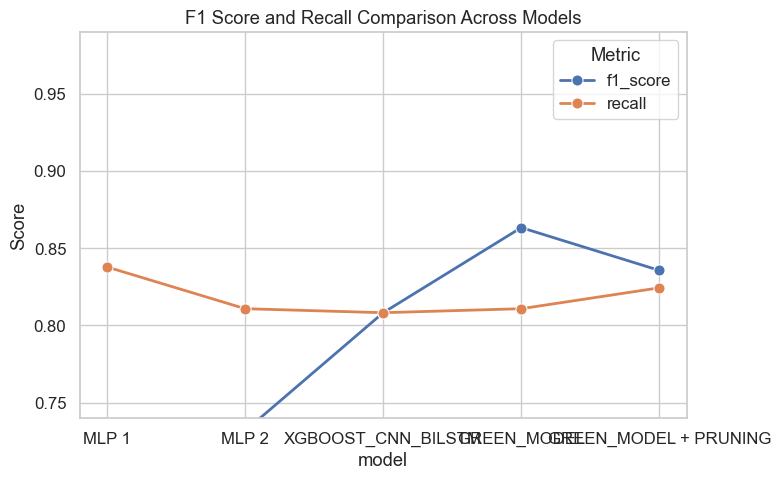

In [21]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_perf.melt(id_vars="model", value_vars=["f1_score", "recall"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="o", linewidth=2, markersize=8)
plt.title("F1 Score and Recall Comparison Across Models")
plt.ylabel("Score")
plt.ylim(0.74, 0.99)
plt.tight_layout()
plt.show()

## Green AI metrics

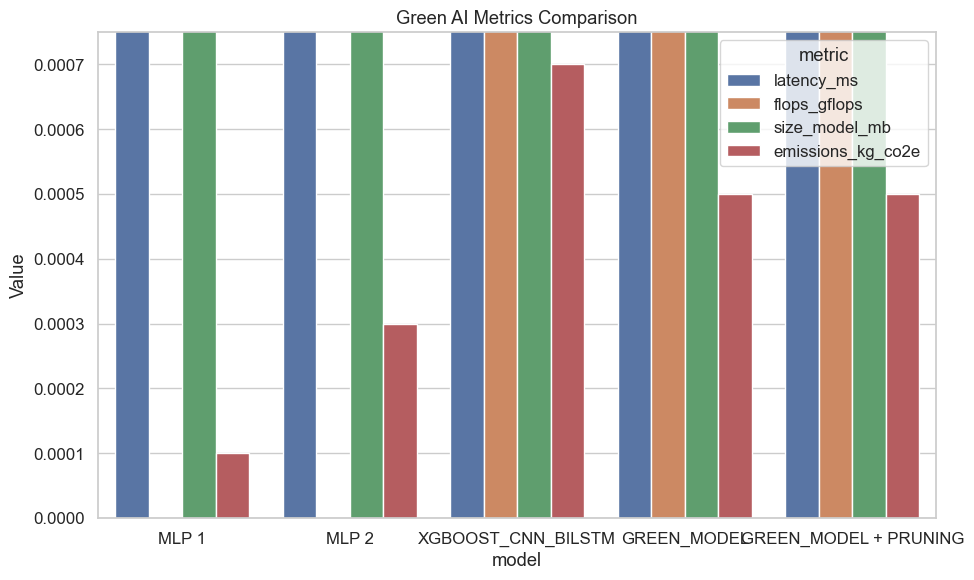

In [22]:
melted_green = df_green.melt(id_vars="model", var_name="metric", value_name="value")
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_green, x="model", y="value", hue="metric", errorbar=None)
plt.title("Green AI Metrics Comparison")
plt.ylim(0.0, 0.00075)
plt.ylabel("Value")
plt.tight_layout()
plt.show()

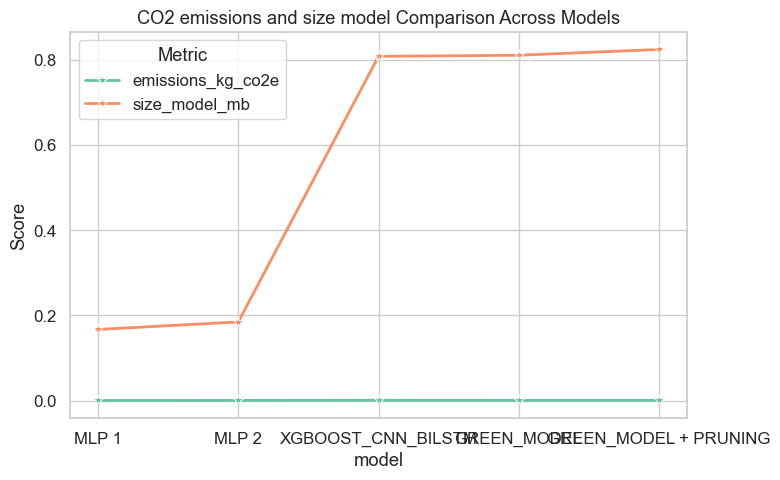

In [23]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_green.melt(id_vars="model", value_vars=["emissions_kg_co2e", "size_model_mb"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="*", linewidth=2, markersize=8, palette="Set2")
plt.title("CO2 emissions and size model Comparison Across Models")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

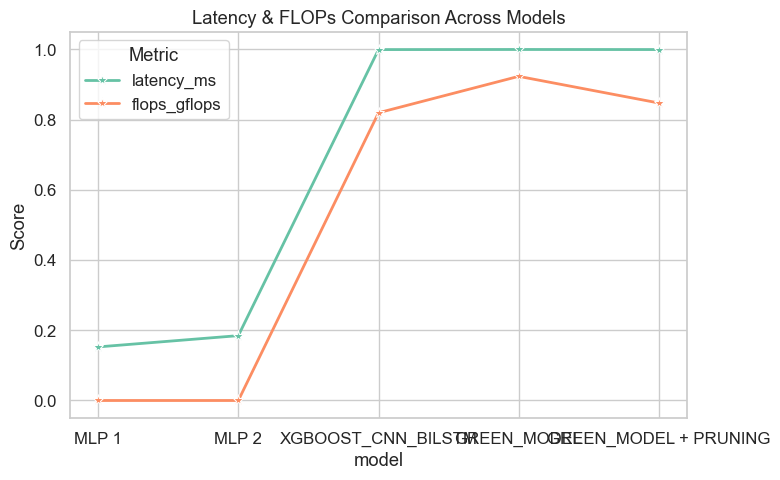

In [24]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_green.melt(id_vars="model", value_vars=["latency_ms", "flops_gflops"],
                               var_name="Metric", value_name="Score"),
             x="model", y="Score", hue="Metric", marker="*", linewidth=2, markersize=8, palette="Set2")
plt.title("Latency & FLOPs Comparison Across Models")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

## Green score 

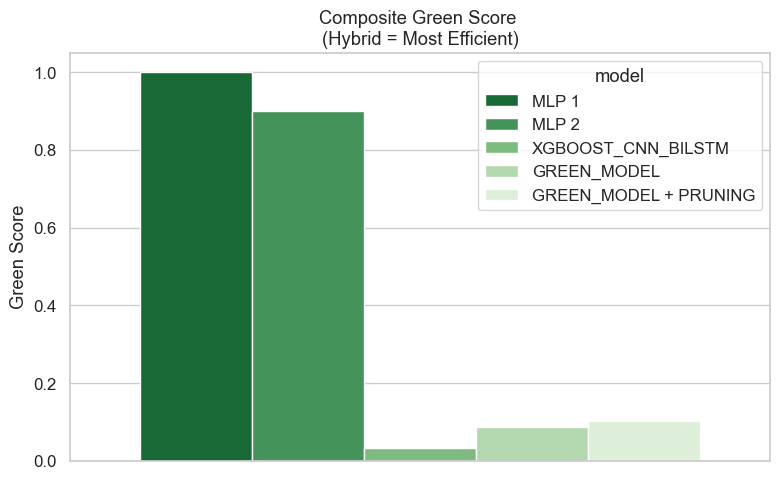

In [25]:
plt.figure(figsize=(8, 5))
sns.barplot(data=df_green_score, hue="model", y="green_score", palette="Greens_r")
plt.title("Composite Green Score \n(Hybrid = Most Efficient)")
plt.ylabel("Green Score")
plt.tight_layout()
plt.show()

## Trade off: F1 vs Emissions

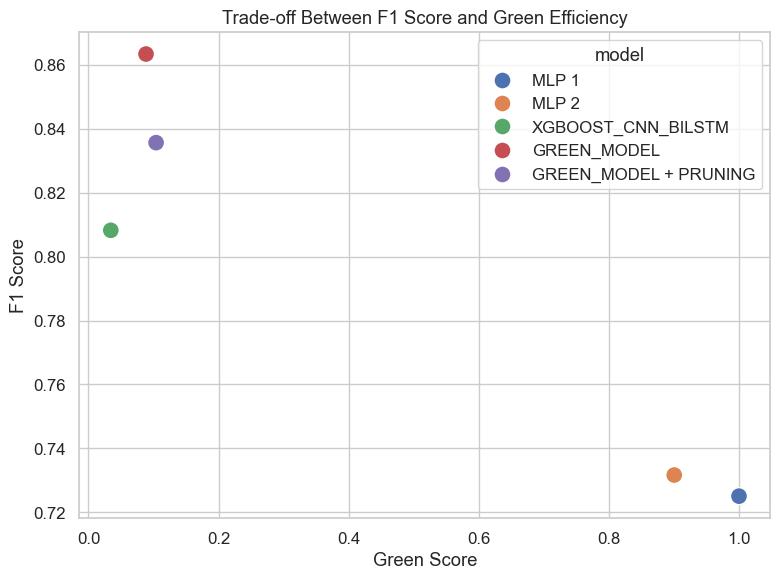

In [26]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_summary, x="green_score", y="f1_score", hue="model", s=150)
plt.title("Trade-off Between F1 Score and Green Efficiency")
plt.xlabel("Green Score")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()

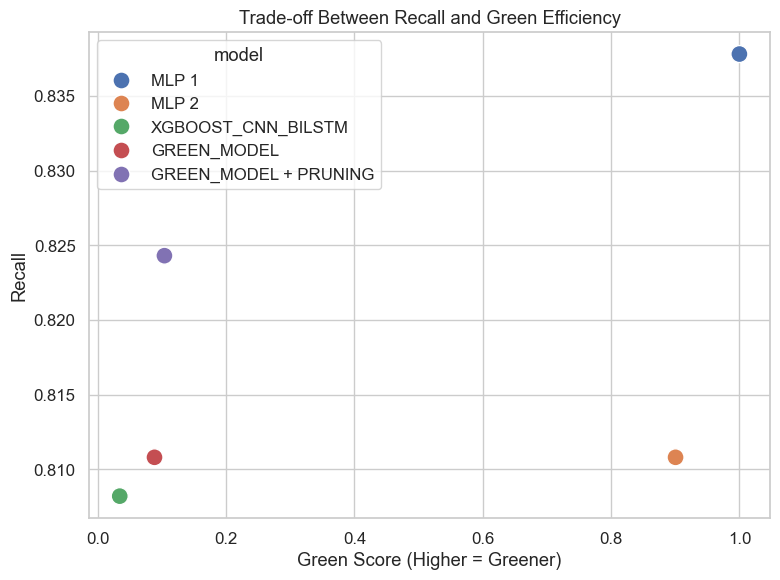

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_summary, x="green_score", y="recall", hue="model", s=150)
plt.title("Trade-off Between Recall and Green Efficiency")
plt.xlabel("Green Score (Higher = Greener)")
plt.ylabel("Recall")
plt.tight_layout()
plt.show()

## Radar Chart -> Performance & Green tradeoff

In [28]:
def radar_chart(df, title, metrics):
    labels = metrics
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    for i, row in df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, label=row["model"])
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    plt.title(title, size=14)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

# Normalize for better visualization
df_green_norm = df_green.copy()
for col in df_green_norm.columns[1:]:
    df_green_norm[col] = (df_green_norm[col] - df_green_norm[col].min()) / (df_green_norm[col].max() - df_green_norm[col].min())

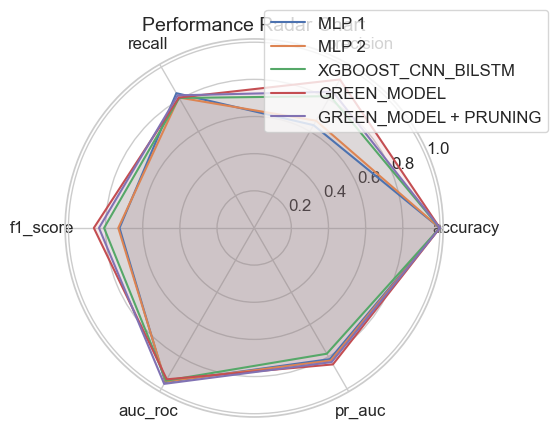

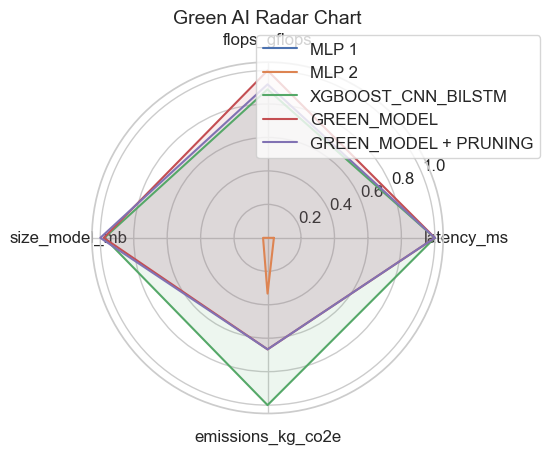

In [29]:
radar_chart(df_perf, "Performance Radar Chart", ["accuracy", "precision", "recall", "f1_score", "auc_roc", "pr_auc"])
radar_chart(df_green_norm, "Green AI Radar Chart", ["latency_ms", "flops_gflops", "size_model_mb", "emissions_kg_co2e"])